In [121]:
# imports
import h2o 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.kmeans import H2OKMeansEstimator
from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator

In [122]:
# display matplotlib graphics in notebook
%matplotlib inline

In [123]:
# start and connect to h2o server
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,4 hours 4 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,3 months and 6 days
H2O cluster name:,kaiyuanluo
H2O cluster total nodes:,1
H2O cluster free memory:,1.594 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [124]:
col_types = {'chain': 'object',
             'offer': 'object',
             'market': 'object',
             'category': 'object',
             'company': 'object',
             'brand': 'object',
             'exact_item_bought': 'object'}

In [125]:
train_pd = pd.read_csv('datasets/assign_05_train.csv', dtype=col_types)
valid_pd = pd.read_csv('datasets/assign_05_valid.csv', dtype=col_types)
test_pd = pd.read_csv('datasets/assign_05_test.csv', dtype=col_types)

In [142]:
col_types = {'chain': 'enum',
             'offer': 'enum',
             'market': 'enum',
             'category': 'enum',
             'company': 'enum',
             'brand': 'enum',
             'exact_item_bought':'enum',
             'month': 'enum',
             'week': 'enum'}

train = h2o.H2OFrame(train_pd, column_types=col_types)
valid = h2o.H2OFrame(valid_pd, column_types=col_types)
test = h2o.H2OFrame(test_pd, column_types=col_types)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [25]:
train.describe()

Rows:64122
Cols:18




,id,chain,offer,market,repeater,offerdate,category,quantity,company,offervalue,brand,avg_category_quantity,avg_category_amount,exact_item_bought,month,week,dayOfWeek,day
type,int,enum,enum,enum,int,int,enum,int,enum,real,enum,real,real,int,int,int,enum,int
mins,86246.0,,,,0.0,1362096000000.0,,1.0,,0.75,,-1.0,-85.14,0.0,3.0,9.0,,1.0
mean,1865046990.7057786,,,,0.2693771248557437,1365226057677.5488,,1.0,,1.2553569757649399,,0.6942286652419994,2.244028120538153,0.5060197748042793,3.5870216150463126,14.372602227004734,,19.02984934967713
maxs,4809911000.0,,,,1.0,1367280000000.0,,1.0,,3.0,,44.181818182,60.802,1.0,4.0,18.0,,31.0
sigma,1567329467.9984748,,,,0.4436396723261261,1304850779.3859916,,0.0,,0.5238038613432824,,0.7714497289290292,2.6319680001789543,0.49996765957894,0.492372845811281,2.1637326586941863,,9.628506814875895
zeros,0,,,,46849,0,,0,,0,,29124,29138,31675,0,0,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,86246.0,205,1208251,34,1.0,1366761600000.0,2202,1.0,104460040,2.0,3718,0.0,0.0,0.0,4.0,17.0,Wed,24.0
1,12682470.0,18,unknown,11,0.0,1364428800000.0,unknown,1.0,unknown,0.75,unknown,1.0,2.5,1.0,3.0,13.0,Thu,28.0
2,13807224.0,4,1204576,1,0.0,1365120000000.0,5616,1.0,104610040,1.0,15889,1.4375,3.365,1.0,4.0,14.0,Fri,5.0


In [143]:
# quantity unary, drop it
# drop other unusable variables
# set modeling roles
y = 'repeater'
X = ['offervalue', 'avg_category_quantity', 'avg_category_amount', 'exact_item_bought', 'month', 'week', 'day']
print(y)
print(X)

repeater
['offervalue', 'avg_category_quantity', 'avg_category_amount', 'exact_item_bought', 'month', 'week', 'day']


In [144]:
train=train[X]

In [145]:
train.head()

offervalue,avg_category_quantity,avg_category_amount,exact_item_bought,month,week,day
2,0,0,0,4,17,24
0.75,1,2.5,1,3,13,28
1,1.4375,3.365,1,4,14,5
0.75,0,0,0,4,14,4
0.75,0,0,0,4,14,2
2,0,0,0,4,17,24
0.75,0,0,0,3,13,26
0.75,1.2,2.728,1,4,14,5
0.75,0,0,0,3,13,28
2,1.16667,11.4883,1,3,12,18


In [146]:
# determine column types
reals, enums = [], []
for key, val in train.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)

print(enums)
print(reals)

['exact_item_bought', 'month', 'week']
['offervalue', 'avg_category_quantity', 'avg_category_amount', 'day']


In [147]:
train.head()

offervalue,avg_category_quantity,avg_category_amount,exact_item_bought,month,week,day
2,0,0,0,4,17,24
0.75,1,2.5,1,3,13,28
1,1.4375,3.365,1,4,14,5
0.75,0,0,0,4,14,4
0.75,0,0,0,4,14,2
2,0,0,0,4,17,24
0.75,0,0,0,3,13,26
0.75,1.2,2.728,1,4,14,5
0.75,0,0,0,3,13,28
2,1.16667,11.4883,1,3,12,18


In [169]:
frame = train

In [172]:
# project training data onto 3-D using principal components
# join with clusters labels
# plot
pca = H2OPrincipalComponentAnalysisEstimator(k=3,seed = 12345, transform = 'standardize') # project onto 3 PCs
pca.train(x=X, training_frame=train)
features = pca.predict(train)
features_pandas = features.as_data_frame()
print(features_pandas.head())

# view detailed results at http://ip:port/flow/index.html

pca Model Build progress: |███████████████████████████████████████████████| 100%


/anaconda3/lib/python3.7/site-packages/h2o/job.py:69: UserWarning: _train: Dataset used may contain fewer number of rows due to removal of rows with NA/missing values.  If this is not desirable, set impute_missing argument in pca call to TRUE/True/true/... depending on the client language.
  warnings.warn(w)


pca prediction progress: |████████████████████████████████████████████████| 100%
        PC1       PC2       PC3
0  1.148992  0.259361  1.891686
1 -0.512041  0.997286 -0.917864
2 -1.938982 -1.370536  0.177618
3  0.224752 -2.263205 -0.225601
4  0.173512 -2.438949 -0.213482


In [133]:
print('ax.azim {}'.format(ax.azim))
print('ax.elev {}'.format(ax.elev))

ax.azim 280
ax.elev 15


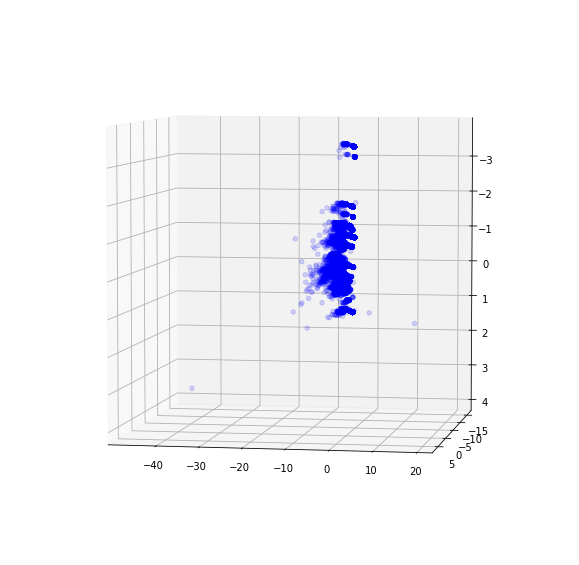

In [134]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(features_pandas.PC1, features_pandas.PC2, -features_pandas.PC3, 
           color = "b", marker='o', alpha=0.15)

ax.view_init(elev = 5, azim = 280)
ax.invert_yaxis()
ax.invert_zaxis()
plt.show()



In [135]:
ot = list(features_pandas[(features_pandas['PC1'] < -40) | (features_pandas['PC1'] > 10)].index)
ot

[2903, 21276]

In [136]:
# REMOVE OUTLIERS
features_pandas = features_pandas.drop(features_pandas[(features_pandas['PC1'] < -40) | 
                                                       (features_pandas['PC1'] > 10)].index)

In [150]:
train_cl = train.drop(ot, axis=0)

In [151]:
train_cl

offervalue,avg_category_quantity,avg_category_amount,exact_item_bought,month,week,day
2,0,0,0,4,17,24
0.75,1,2.5,1,3,13,28
1,1.4375,3.365,1,4,14,5
0.75,0,0,0,4,14,4
0.75,0,0,0,4,14,2
2,0,0,0,4,17,24
0.75,0,0,0,3,13,26
0.75,1.2,2.728,1,4,14,5
0.75,0,0,0,3,13,28
2,1.16667,11.4883,1,3,12,18


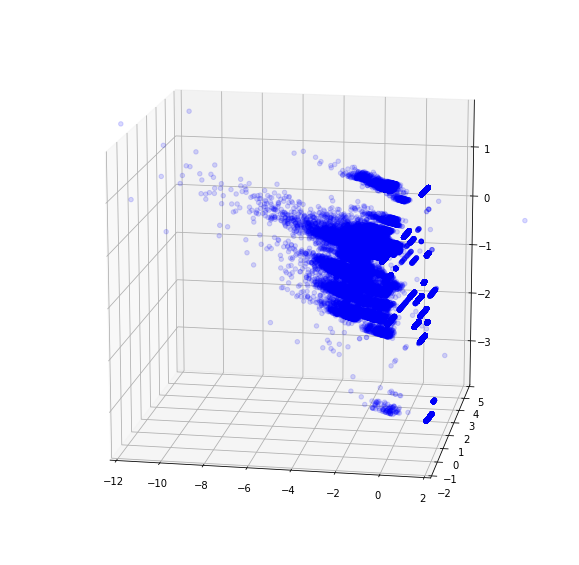

In [114]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(features_pandas.PC1, features_pandas.PC2, -features_pandas.PC3, 
           color = "b", marker='o', alpha=0.15)

ax.set_xlim3d(-12, 2)
ax.set_ylim3d(-2, 5)
ax.view_init(elev = 15, azim = 280)

#ax.invert_yaxis()
#ax.invert_zaxis()
plt.show()

In [173]:
# project training data onto 3-D using principal components
# join with clusters labels
# plot
pca = H2OPrincipalComponentAnalysisEstimator(k=3,seed = 12345, transform = 'standardize') # project onto 3 PCs
pca.train(x=X, training_frame=train_cl)
features = pca.predict(train_cl)
features_pandas_cl = features.as_data_frame()
print(features_pandas_cl.head())

# view detailed results at http://ip:port/flow/index.html

pca Model Build progress: |███████████████████████████████████████████████| 100%


/anaconda3/lib/python3.7/site-packages/h2o/job.py:69: UserWarning: _train: Dataset used may contain fewer number of rows due to removal of rows with NA/missing values.  If this is not desirable, set impute_missing argument in pca call to TRUE/True/true/... depending on the client language.
  warnings.warn(w)


pca prediction progress: |████████████████████████████████████████████████| 100%
        PC1       PC2       PC3
0  1.171114  0.261399  1.891452
1 -0.521982  1.003862 -0.920096
2 -1.954346 -1.364447  0.179709
3  0.250301 -2.263812 -0.221344
4  0.199387 -2.439821 -0.208899


In [138]:
# train k-means cluster model
# print summary
twce = {'k':[], 'total within cluster error':[]}
for i in range(1,11):
    twce['k'].append(i)
    clusters = H2OKMeansEstimator(standardize=False, k=i, seed=12345)
    clusters.train(x=X, training_frame=train_cl)
    twce['total within cluster error'].append(clusters.tot_withinss())

twce_df = pd.DataFrame.from_dict(twce)

# view detailed results at http://ip:port/flow/index.html

kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%


In [116]:
twce_df

,k,total within cluster error
0,1,355867.063099
1,2,234238.799360
2,3,180315.959000
3,4,157278.715821
4,5,121566.251169
5,6,129290.694554
6,7,111002.340454
7,8,97537.597935
8,9,95484.780851
9,10,80235.472005


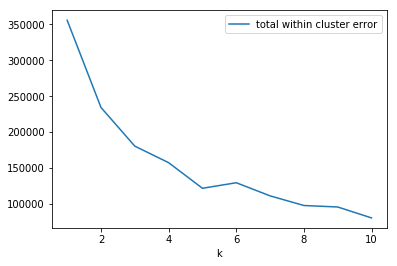

In [117]:
twce_df.plot(x='k',y='total within cluster error')

In [152]:
# train k-means cluster model
# print summary
clusters = H2OKMeansEstimator(standardize=False, k=5, seed=12345)
clusters.train(x=X, training_frame=train_cl)
print(clusters)

kmeans Model Build progress: |████████████████████████████████████████████| 100%
Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1556819162453_90


ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 608255.8158765391
Total Sum of Square Error to Grand Mean: 6536415.331341904
Between Cluster Sum of Square Error: 5928159.515465365
Centroid Statistics: 


,centroid,size,within_cluster_sum_of_squares
,1.0,24868.0,186396.3121250
,2.0,796.0,26174.0436772
,3.0,13717.0,118475.5945828
,4.0,15803.0,162960.3162344
,5.0,8936.0,114249.5492571


Scoring History: 


,timestamp,duration,iterations,number_of_reassigned_observations,within_cluster_sum_of_squares
,2019-05-02 17:55:32,0.012 sec,0.0,nan,nan
,2019-05-02 17:55:32,0.284 sec,1.0,64120.0,2097370.7326720
,2019-05-02 17:55:32,0.297 sec,2.0,6404.0,1126358.3537708
,2019-05-02 17:55:32,0.310 sec,3.0,2315.0,872713.9075050
,2019-05-02 17:55:32,0.324 sec,4.0,1322.0,811301.3977181
,2019-05-02 17:55:32,0.336 sec,5.0,2142.0,767279.3007245
,2019-05-02 17:55:32,0.347 sec,6.0,3029.0,719121.5546685
,2019-05-02 17:55:32,0.359 sec,7.0,3315.0,673743.0306921
,2019-05-02 17:55:32,0.371 sec,8.0,2570.0,641105.2653590
,2019-05-02 17:55:32,0.384 sec,9.0,1613.0,623872.7560410


In [181]:
# join cluster labels to original data for further analysis
labels = clusters.predict(train_cl)
labeled_train = train_cl.cbind(labels)
labeled_train.head()

kmeans prediction progress: |█████████████████████████████████████████████| 100%


offervalue,avg_category_quantity,avg_category_amount,exact_item_bought,month,week,day,predict
2,0,0,0,4,17,24,0
0.75,1,2.5,1,3,13,28,0
1,1.4375,3.365,1,4,14,5,3
0.75,0,0,0,4,14,4,3
0.75,0,0,0,4,14,2,3
2,0,0,0,4,17,24,0
0.75,0,0,0,3,13,26,0
0.75,1.2,2.728,1,4,14,5,3
0.75,0,0,0,3,13,28,0
2,1.16667,11.4883,1,3,12,18,1


In [178]:
# define a function for plotting clusters in 3-d
def plot(_3d_labeled_frame):

    _0 = ax.scatter(features_pandas_cl[_3d_labeled_frame.label == 0].PC1, 
                     features_pandas_cl[_3d_labeled_frame.label == 0].PC2,
                     -features_pandas_cl[_3d_labeled_frame.label == 0].PC3,
                     color='m', alpha=.15)

    _1 = ax.scatter(features_pandas_cl[_3d_labeled_frame.label == 1].PC1, 
                     features_pandas_cl[_3d_labeled_frame.label == 1].PC2,
                     -features_pandas_cl[_3d_labeled_frame.label == 1].PC3,
                     color='red', alpha=.15)

    _2 = ax.scatter(features_pandas_cl[_3d_labeled_frame.label == 2].PC1, 
                     features_pandas_cl[_3d_labeled_frame.label == 2].PC2,
                     -features_pandas_cl[_3d_labeled_frame.label == 2].PC3,
                     color='blue', alpha=.15)
    
    _3 = ax.scatter(features_pandas_cl[_3d_labeled_frame.label == 3].PC1, 
                     features_pandas_cl[_3d_labeled_frame.label == 3].PC2,
                     -features_pandas_cl[_3d_labeled_frame.label == 3].PC3,
                     color='green', alpha=.15)
    
    _4 = ax.scatter(features_pandas_cl[_3d_labeled_frame.label == 4].PC1, 
                     features_pandas_cl[_3d_labeled_frame.label == 4].PC2,
                     -features_pandas_cl[_3d_labeled_frame.label == 4].PC3,
                     color='aqua', alpha=.15)
    
    _5 = ax.scatter(features_pandas_cl[_3d_labeled_frame.label == 5].PC1, 
                     features_pandas_cl[_3d_labeled_frame.label == 5].PC2,
                     -features_pandas_cl[_3d_labeled_frame.label == 5].PC3,
                     color='pink', alpha=.15)
                     
    plt.legend([_0, _1, _2, _3, _4, _5], 
               ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
               bbox_to_anchor=(1.05, 0.0), 
               loc=3, borderaxespad=0.)
    

        PC1       PC2       PC3  label
0  1.171114  0.261399  1.891452      0
1 -0.521982  1.003862 -0.920096      0
2 -1.954346 -1.364447  0.179709      3
3  0.250301 -2.263812 -0.221344      3
4  0.199387 -2.439821 -0.208899      3


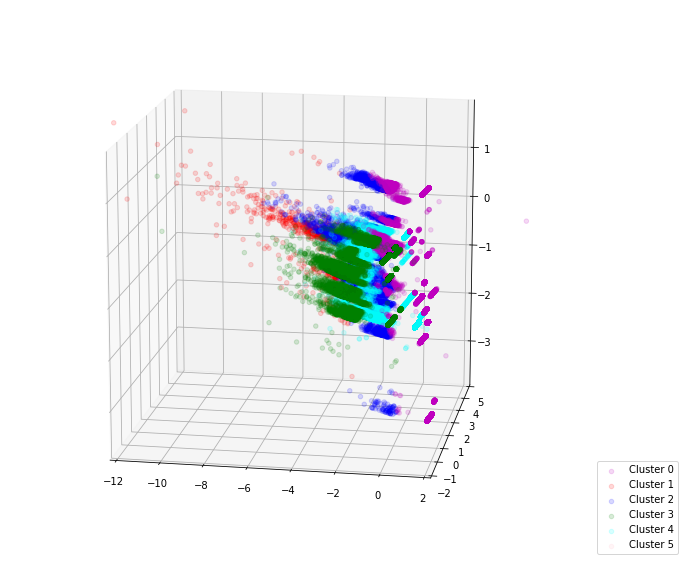

In [179]:
# project training data onto 2-D using principal components
# join with clusters labels
# plot
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
features_pandas_cl['label'] = labeled_train[-1].as_data_frame()
print(features_pandas_cl.head())
plot(features_pandas_cl)
ax.set_xlim3d(-12, 2)
ax.set_ylim3d(-2, 5)
ax.view_init(elev = 15, azim = 280)

#ax.invert_yaxis()
#ax.invert_zaxis()
plt.show()
# view detailed results at http://ip:port/flow/index.html


In [182]:
# profile clusters by means
grouped = labeled_train.group_by(by=['predict'])
means = grouped.mean(col=reals).get_frame()
print(means)

predict,mean_offervalue,mean_avg_category_quantity,mean_avg_category_amount,mean_day
0,1.30552,0.162698,0.392527,26.6125
1,1.23398,2.71193,12.8494,24.1256
2,1.18249,1.38942,4.55474,24.8171
3,1.05814,0.88068,2.72782,4.00734
4,1.57836,0.591803,2.05345,15.1564


In [183]:
h2o.cluster().shutdown(prompt = False)

H2O session _sid_9061 closed.
